In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
def collect_data_and_plot(df, n_stores, n_warehouses, n_samples, test_mode, setting_name, is_profit=False):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'] + '/model.pt',
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/{setting_name}/{n_stores}-{n_warehouses}/{row['Architecture Class']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 8:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_profit_or_cost = []
    w_holding_by_warehouse_all = []
    w_edge_costs_by_warehouse_all = []
    relevant_data_for_all = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        batch_size = n_samples
        num_batches = n_samples // batch_size
        if test_mode == 'test_on_dev':
            num_steps = 100
            start_step = 30
        else:
            num_steps = 500
            start_step = 300
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        s_underage = relevant_data['s_underage_costs'].sum()
        s_holding = relevant_data['s_holding_costs'].sum()
        
        # Split warehouse holding costs by warehouse
        w_holding_costs = []
        w_edge_costs = []
        for i in range(n_warehouses):
            w_holding_costs.append(relevant_data[f'w_{i}_holding_costs'].sum())
            w_edge_costs.append(relevant_data[f'w_{i}_edge_costs'].sum())
            
        w_holding = sum(w_holding_costs)
        w_edge = sum(w_edge_costs)
        
        avg_s_underage.append(s_underage)
        avg_s_holding.append(s_holding)
        w_holding_by_warehouse_all.append(w_holding_costs)
        w_edge_costs_by_warehouse_all.append(w_edge_costs)
        avg_w_holding.append(w_holding)
        
        if is_profit:
            # For profit: negate underage (revenue) and subtract costs
            profit = -s_underage - s_holding - w_holding - w_edge
            avg_profit_or_cost.append(profit)
        else:
            # For loss: sum all costs
            cost = s_underage + s_holding + w_holding + w_edge
            avg_profit_or_cost.append(cost)

        relevant_data_for_all.append(relevant_data)

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = [-x if is_profit else x for x in avg_s_underage]
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding
    
    # Add individual warehouse holding costs and edge costs
    for i in range(n_warehouses):
        df_copy[f'w_{i}_holding'] = [x[i] for x in w_holding_by_warehouse_all]
        df_copy[f'w_{i}_edge_costs'] = [x[i] for x in w_edge_costs_by_warehouse_all]
        
    metric_name = 'avg_profit' if is_profit else 'avg_lost_sales'
    df_copy[metric_name] = avg_profit_or_cost
    df = df_copy

    # Calculate relative metric as percentage of best value
    if is_profit:
        best_value = df[metric_name].max()
        df['relative_metric'] = df[metric_name] / best_value * 100
    else:
        best_value = df[metric_name].min()
        df['relative_metric'] = df[metric_name] / best_value * 100

    plot_data = df.pivot(columns='Architecture Class', 
                        values=['relative_metric', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'] + 
                        [f'w_{i}_holding' for i in range(n_warehouses)] +
                        [f'w_{i}_edge_costs' for i in range(n_warehouses)])
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    axes = axes.flatten()
    
    metric_title = 'Profit' if is_profit else 'Loss'
    titles = [f'{metric_title} (% of {"maximum" if is_profit else "minimum"})', 
              'Store Revenue(1e7)' if is_profit else 'Store Lost Sales(1e7)', 
              'Store Holding Cost(1e7)', 
              'Total Warehouse Holding Cost(1e7)', 
              'Total Warehouse Edge Cost(1e7)',
              'Individual Warehouse Holding Costs(1e7)',
              'Individual Warehouse Edge Costs(1e7)']
    y_values = ['relative_metric', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']
    
    # Calculate total edge costs for each architecture
    total_edge_costs = {}
    for arch in df['Architecture Class'].unique():
        edge_cost_cols = [f'w_{i}_edge_costs' for i in range(n_warehouses)]
        total_edge_costs[arch] = sum(plot_data[col][arch] for col in edge_cost_cols)
        plot_data[('avg_w_edge', arch)] = total_edge_costs[arch]

    # Add total edge costs to y_values
    y_values.append('avg_w_edge')

    # Create a single legend at the top
    legend_lines = []
    legend_labels = []
    for arch in df['Architecture Class'].unique():
        legend_lines.append(plt.Line2D([0], [0], color=color_scheme[arch], marker='o', markersize=10))
        legend_labels.append(arch)
    
    fig.legend(legend_lines, legend_labels, loc='upper center', 
              bbox_to_anchor=(0.5, 0.98), ncol=len(legend_labels))

    for i, (ax, title, y_value) in enumerate(zip(axes[:-2], titles[:-2], y_values)):
        for arch in df['Architecture Class'].unique():
            if y_value == 'avg_w_edge':
                plot_values = total_edge_costs[arch].to_numpy() / 1e7
            elif arch in plot_data[y_value].columns:
                plot_values = plot_data[y_value][arch].to_numpy()
                if y_value != 'relative_metric':
                    plot_values = plot_values / 1e7
            x_values = np.ones_like(plot_values)
            ax.plot(x_values, plot_values, marker='o', markersize=10,
                   color=color_scheme[arch])
        
        ax.set_ylabel(title)
        ax.set_title(title)
        ax.grid(True)
        ax.set_xticks([])

    # Plot individual warehouse holding costs
    for arch in df['Architecture Class'].unique():
        for i in range(n_warehouses):
            if arch in plot_data[f'w_{i}_holding'].columns:
                plot_values = plot_data[f'w_{i}_holding'][arch].to_numpy() / 1e7
                x_values = np.ones_like(plot_values) * (i + 1)
                axes[-2].plot(x_values, plot_values, marker='o', markersize=10,
                            color=color_scheme[arch])

    axes[-2].set_ylabel('Warehouse Holding Cost(1e7)')
    axes[-2].set_title('Individual Warehouse Holding Costs(1e7)')
    axes[-2].grid(True)
    axes[-2].set_xticks(range(1, n_warehouses + 1))
    axes[-2].set_xticklabels([f'W{i}' for i in range(n_warehouses)])

    # Plot individual warehouse edge costs
    for arch in df['Architecture Class'].unique():
        for i in range(n_warehouses):
            if arch in plot_data[f'w_{i}_edge_costs'].columns:
                plot_values = plot_data[f'w_{i}_edge_costs'][arch].to_numpy() / 1e7
                x_values = np.ones_like(plot_values) * (i + 1)
                axes[-1].plot(x_values, plot_values, marker='o', markersize=10,
                            color=color_scheme[arch])

    axes[-1].set_ylabel('Warehouse Edge Cost(1e7)')
    axes[-1].set_title('Individual Warehouse Edge Costs(1e7)')
    axes[-1].grid(True)
    axes[-1].set_xticks(range(1, n_warehouses + 1))
    axes[-1].set_xticklabels([f'W{i}' for i in range(n_warehouses)])

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    return df, relevant_data_for_all


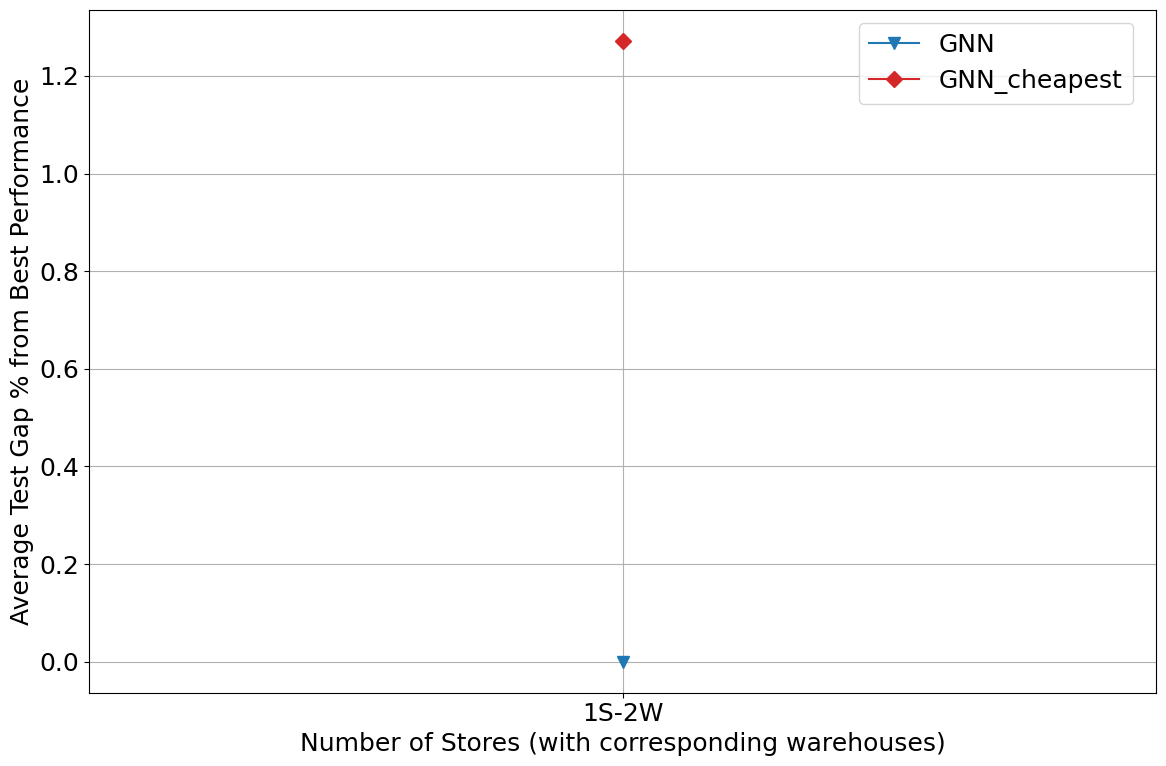

In [5]:
# Create vanilla results dataframe from the provided data
testset_names = ["n_warehouse_1_2_edge_cost"]# ["n_warehouse_20_2", "n_warehouse_40_3"]#, "n_warehouse_50_4"]
store_warehouse_pairs = {
    1: 2,
    40: 3,
    50: 4
}

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme and markers
color_scheme = {
    "Vanilla NN": "#ff7f0e",    # Blue
    "GNN": "#1f77b4",          # Green
    "GNN_cheapest": "#d62728",  # Red
}

marker_scheme = {
    "Vanilla NN": "o",         # Circle
    "GNN": "v",               # Down triangle
    "GNN_cheapest": "D",      # Diamond
}

# Define paths for each architecture
architectures = {
    "GNN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN',
    "GNN_cheapest": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_cheapest',
}

architectures_hyperparam_names = {
    "GNN": "GNN",
    "GNN_cheapest": "GNN_cheapest",
}


sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define store sizes and sample size
store_sizes = [1]  # Corresponding to the testset names
sample_size = 8192

dfs = []

# Create dataframes for each architecture, store size and sample size
for arch_name, path_fn in architectures.items():
    for testset_name in testset_names:
        path = path_fn(testset_name)
        store_size = int(testset_name.split('_')[2])
        warehouse_size = store_warehouse_pairs[store_size]
        
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': [sample_size],
             'samples': [1]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
            test_loss_limit = 100)
        if df.empty:
            continue
        
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', architectures_hyperparam_names[arch_name])
        df['train_dev_sample_and_batch_size'] = sample_size
        df['n_warehouses'] = warehouse_size
        df['n_stores'] = store_size
        dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate gap percentage using best performing loss for each store size
stats_by_arch_and_stores = {}
for store_size in store_sizes:
    store_data = df[df['n_stores'] == store_size].copy()
    if store_data.empty:
        continue
    best_test_loss = store_data['Test Loss'].min()
    store_data.loc[:, 'Gap %'] = ((store_data['Test Loss'] - best_test_loss) / best_test_loss) * 100
    
    for arch in store_data['Architecture Class'].unique():
        key = arch
        if key not in stats_by_arch_and_stores:
            stats_by_arch_and_stores[key] = []
            
        sample_data = store_data[store_data['Architecture Class'] == arch]
        if not sample_data.empty:
            gaps = sample_data['Gap %'].to_numpy()
            mean_gap = np.mean(gaps)
            std_gap = np.std(gaps)
            ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
            stats_by_arch_and_stores[key].append({
                'n_stores': store_size,
                'mean_gap': mean_gap,
                'ci_lower': mean_gap - ci_95,
                'ci_upper': mean_gap + ci_95
            })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch, stats in stats_by_arch_and_stores.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        # Convert pandas series to numpy arrays before plotting
        stores_array = stats_df['n_stores'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(stores_array, mean_gap_array,
                marker=marker_scheme[arch],
                color=color_scheme[arch],
                linestyle='-',
                markersize=8,
                label=arch)
        
        plt.fill_between(stores_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[arch],
                        alpha=0.1)

plt.xlabel('Number of Stores (with corresponding warehouses)', fontsize=FONTSIZE)
plt.ylabel('Average Test Gap % from Best Performance', fontsize=FONTSIZE)
plt.grid(True)

# Create single legend for architectures
plt.legend(bbox_to_anchor=(0.99, 1),
          loc='upper right',
          fontsize=FONTSIZE)

# Update x-axis ticks to show store-warehouse pairs
plt.xticks(store_sizes, [f'{s}S-{store_warehouse_pairs[s]}W' for s in store_sizes], fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

In [6]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,samples,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,n_warehouses,n_stores
0,1,GNN,8192,GNN,1,0.001,5.751382,5.769080,5.759575,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_1...,2,1
1,1,GNN_cheapest,8192,GNN_cheapest,1,0.001,5.828830,5.843961,5.832814,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_1...,2,1


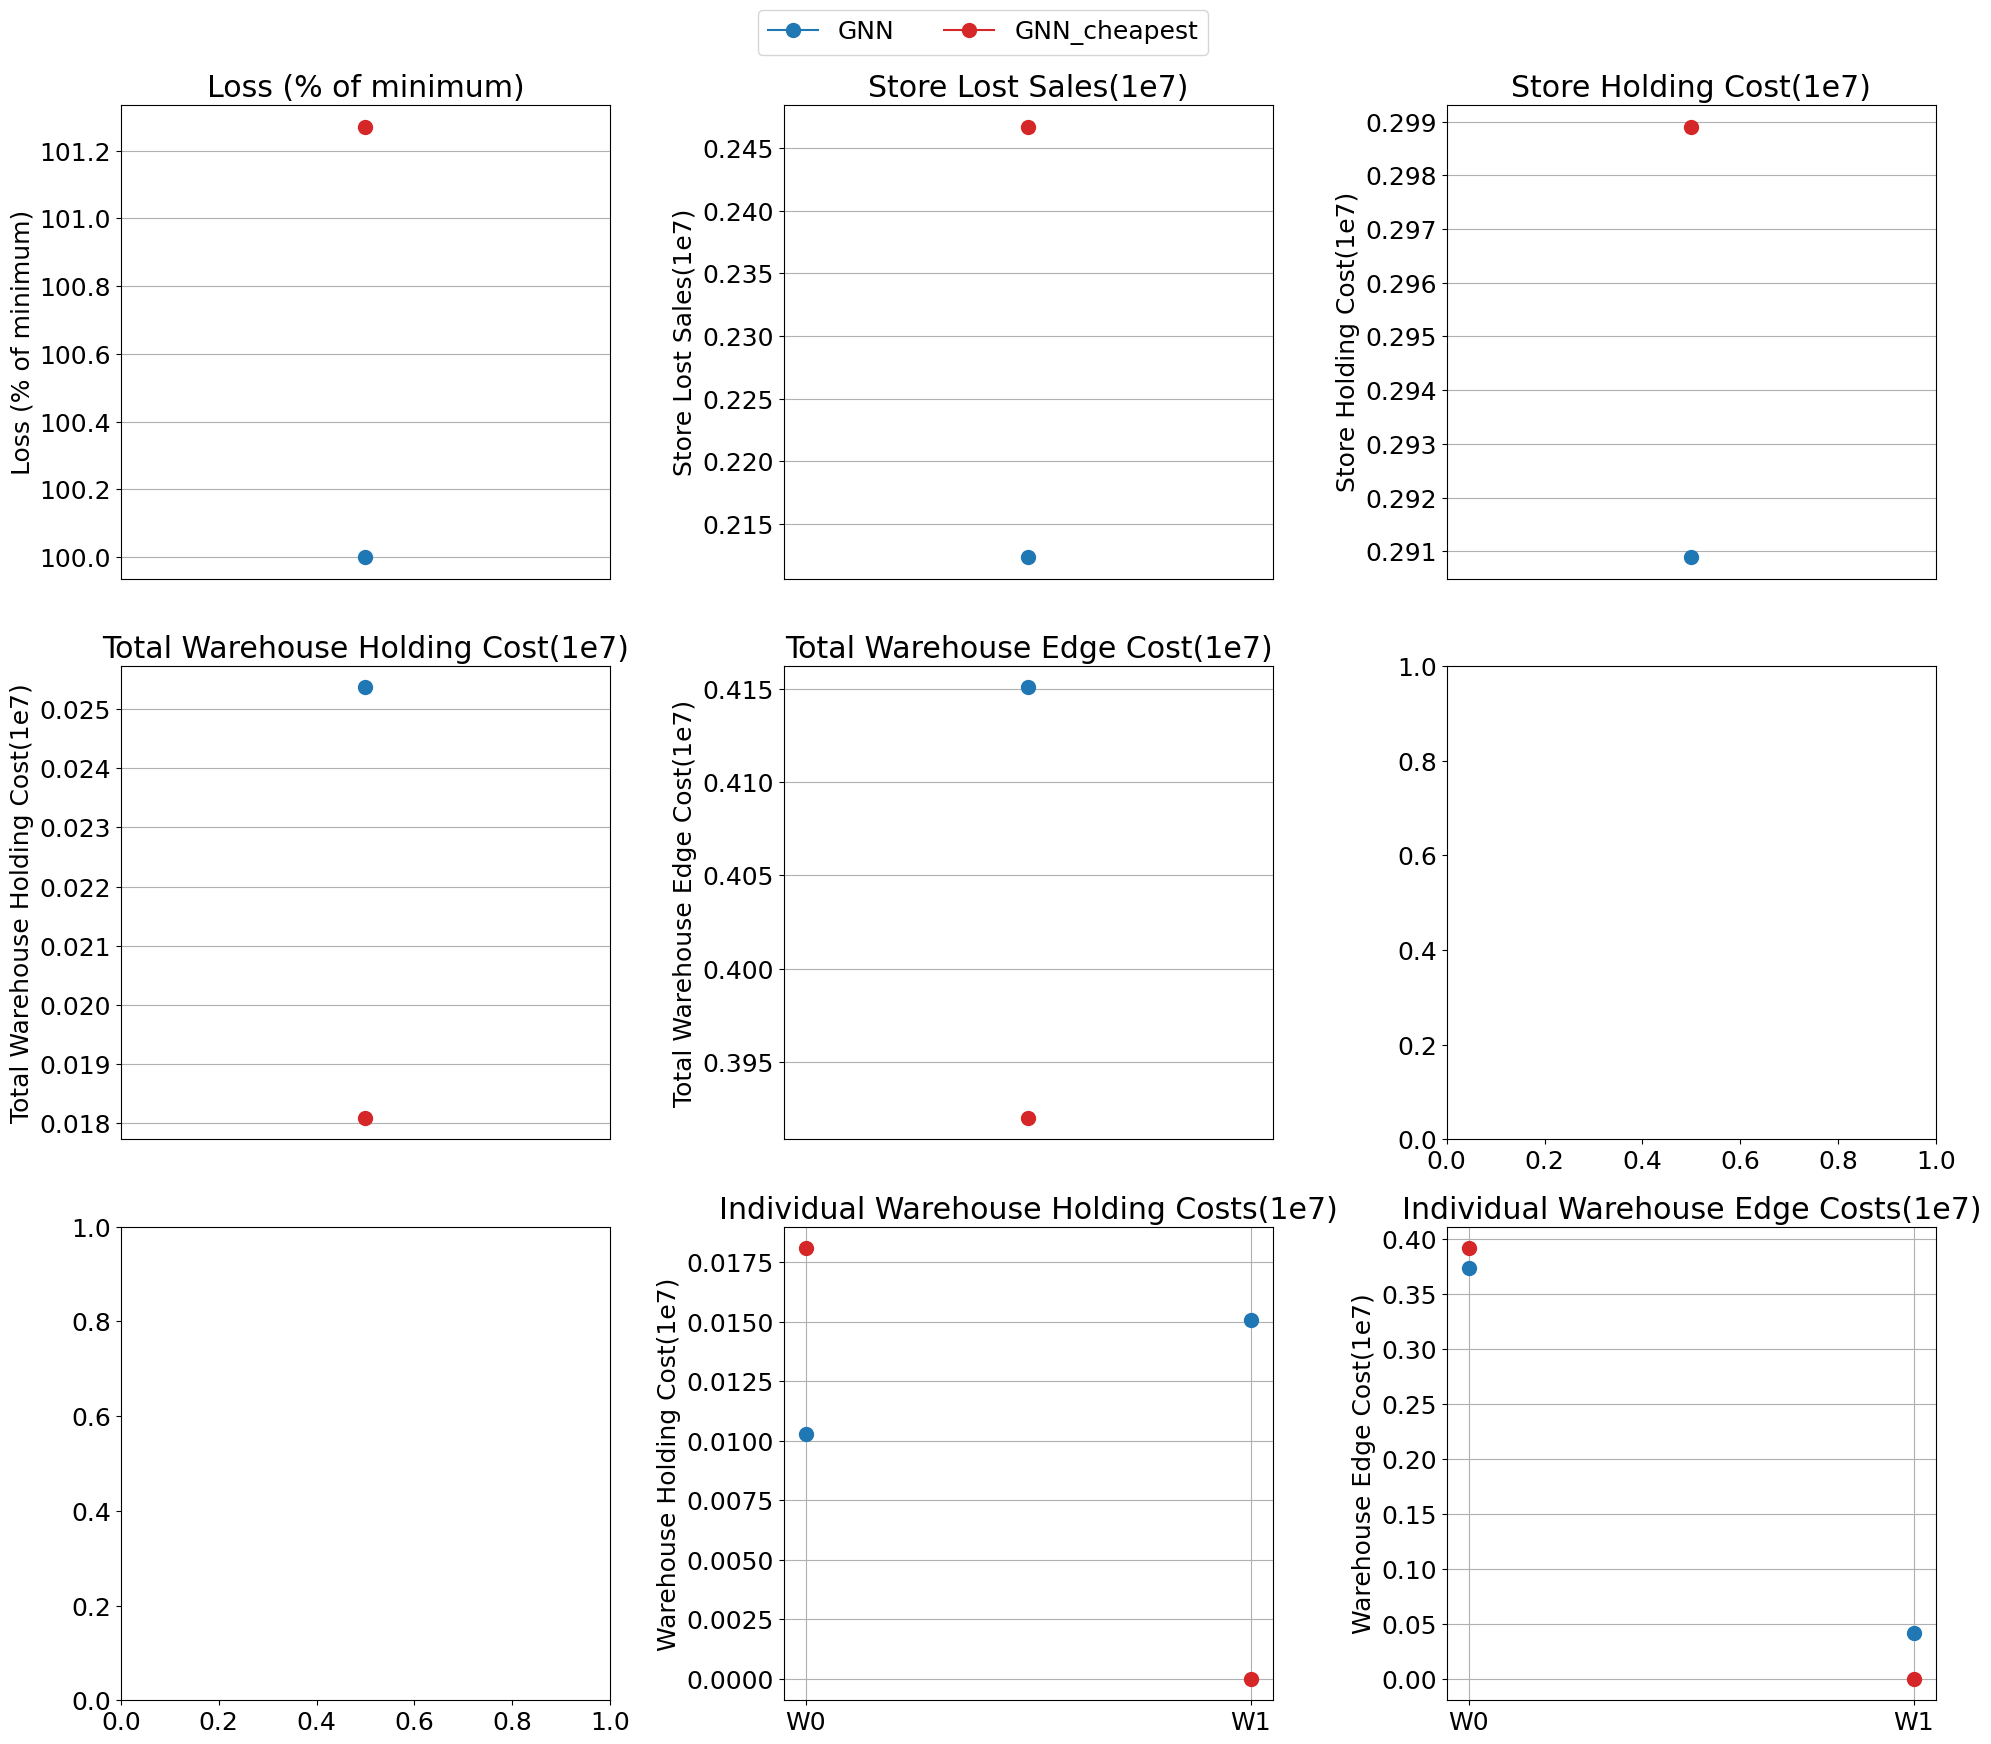

In [7]:
# df_analysis = df[df['Architecture Class'] == 'GNN']
df_analysis = df
df, data = collect_data_and_plot(df_analysis, 1, 2, 8192, "test", "n_warehouse_1_2_lost_demand_edge_cost", False)

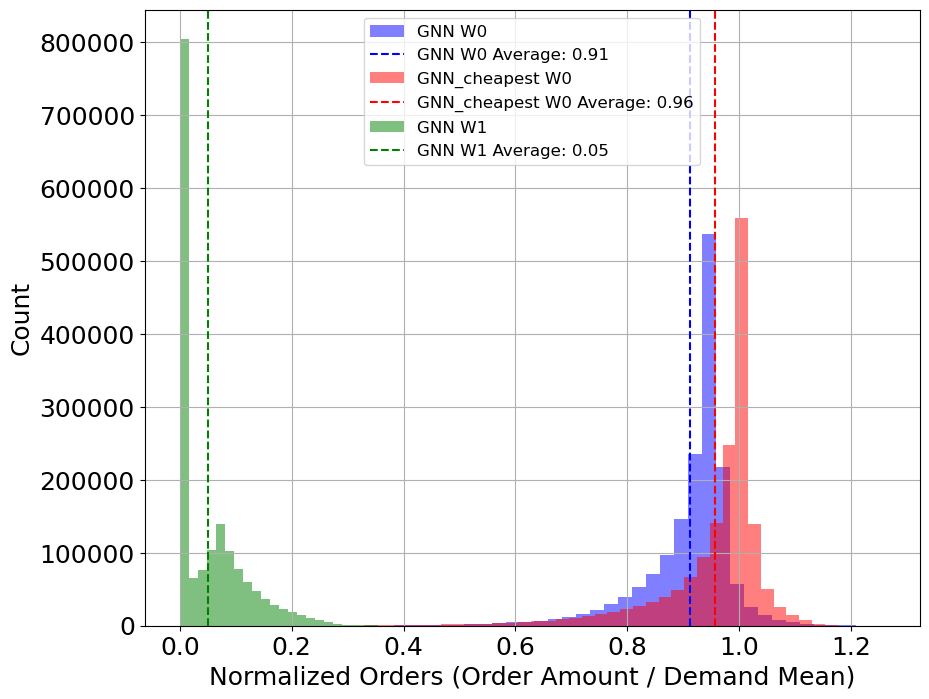

In [9]:
# Process data for both architectures
all_w0_orders = []
all_w1_orders = []
arch_labels = ['GNN', 'GNN_cheapest']
colors = ['blue', 'red', 'green']

n_samples = 8192
n_steps = int(data[0].shape[0] / n_samples)

for arch_idx in range(2):
    target_data = data[arch_idx]
    w0_orders = []
    w1_orders = []

    for t in range(n_steps-1):
        # Get indices for this timestep across all samples
        current_step_indices = range(t * n_samples, (t + 1) * n_samples)
        
        # For each store, get w0 orders normalized by demand mean
        for store_idx in range(1):
            w0_order = target_data[f's_{store_idx}_w_0_order'].iloc[current_step_indices].values
            if arch_idx == 0:  # Only for GNN
                w1_order = target_data[f's_{store_idx}_w_1_order'].iloc[current_step_indices].values
            demand_mean = target_data[f's_{store_idx}_demand_mean'].iloc[current_step_indices].values
            demand_std = target_data[f's_{store_idx}_demand_std'].iloc[current_step_indices].values
            normalized_w0_order = (w0_order / demand_mean)
            w0_orders.extend(normalized_w0_order)
            if arch_idx == 0:  # Only for GNN
                normalized_w1_order = (w1_order / demand_mean)
                w1_orders.extend(normalized_w1_order)
    
    all_w0_orders.append(np.array(w0_orders))
    if arch_idx == 0:  # Only for GNN
        all_w1_orders = np.array(w1_orders)

# Sample 10000 points from each architecture's data
plt.figure(figsize=(10, 8))
for arch_idx in range(2):
    sampled_data = all_w0_orders[arch_idx]
    mean_value = np.mean(all_w0_orders[arch_idx])
    
    plt.hist(sampled_data, bins=50, alpha=0.5, 
             label=f'{arch_labels[arch_idx]} W0', color=colors[arch_idx])
    plt.axvline(x=mean_value, color=colors[arch_idx], linestyle='--', 
                label=f'{arch_labels[arch_idx]} W0 Average: {mean_value:.2f}')

# Add W1 orders for GNN
mean_value = np.mean(all_w1_orders)
plt.hist(all_w1_orders, bins=50, alpha=0.5,
         label='GNN W1', color=colors[2])
plt.axvline(x=mean_value, color=colors[2], linestyle='--',
            label=f'GNN W1 Average: {mean_value:.2f}')

plt.xlabel('Normalized Orders (Order Amount / Demand Mean)')
plt.ylabel('Count')
#plt.legend()
plt.legend(prop={'size': 12})
plt.grid(True)
plt.show()

/tmp/ipykernel_16956/1115570544.py:40: RuntimeWarning: invalid value encountered in true_divide
  mean_hist = hist / counts


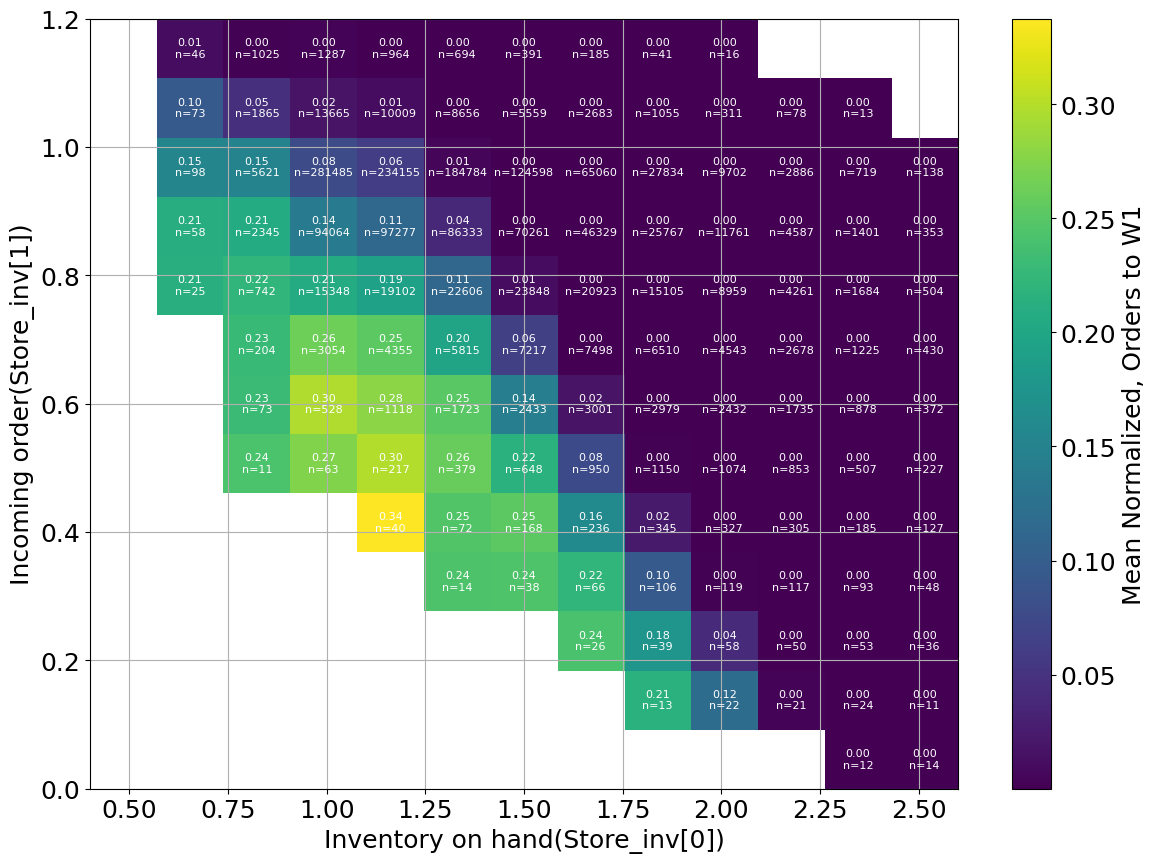

In [11]:
target_data = data[0]
n_samples = 8192
all_inv0 = []
all_inv1 = []
all_w1_orders = []

for t in range(n_steps-1):
    # Get indices for this timestep across all samples
    current_step_indices = range(t * n_samples, (t + 1) * n_samples)
    
    for store_idx in range(1):
        inv0 = target_data[f's_{store_idx}_inventory_0'].iloc[current_step_indices].values
        inv1 = target_data[f's_{store_idx}_inventory_1'].iloc[current_step_indices].values
        w1_orders = target_data[f's_{store_idx}_w_1_order'].iloc[current_step_indices].values
        demand_mean = target_data[f's_{store_idx}_demand_mean'].iloc[current_step_indices].values
        
        # Normalize values
        normalized_inv0 = inv0 / demand_mean
        normalized_inv1 = inv1 / demand_mean
        normalized_w1_orders = w1_orders / demand_mean
        
        all_inv0.extend(normalized_inv0)
        all_inv1.extend(normalized_inv1)
        all_w1_orders.extend(normalized_w1_orders)

# Convert to numpy arrays
all_inv0 = np.array(all_inv0)
all_inv1 = np.array(all_inv1)
all_w1_orders = np.array(all_w1_orders)

# Create 2D histogram with fewer bins
n_bins = 13
n_samples_cut = 10
x_bins = np.linspace(0.4, 2.6, n_bins+1)
y_bins = np.linspace(0.0, 1.2, n_bins+1)
hist, xedges, yedges = np.histogram2d(all_inv0, all_inv1, bins=[x_bins, y_bins], weights=all_w1_orders)
counts, _, _ = np.histogram2d(all_inv0, all_inv1, bins=[x_bins, y_bins])

# Calculate mean values in each bin
mean_hist = hist / counts
mean_hist[counts == 0] = np.nan
mean_hist[counts < n_samples_cut] = np.nan  # Mask bins with less than 20 samples

plt.figure(figsize=(14, 10))
plt.imshow(mean_hist.T, origin='lower', aspect='auto',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           cmap='viridis')

# Add text annotations for bin values and counts
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
for i in range(len(x_centers)):
    for j in range(len(y_centers)):
        if not np.isnan(mean_hist[i,j]) and counts[i,j] >= n_samples_cut:
            plt.text(x_centers[i], y_centers[j], 
                    f'{mean_hist[i,j]:.2f}\nn={int(counts[i,j])}',
                    ha='center', va='center', color='white', fontsize=8)

plt.xlim(0.4, 2.6)
plt.ylim(0.0, 1.2)

plt.colorbar(label='Mean Normalized, Orders to W1')
plt.xlabel('Inventory on hand(Store_inv[0])')
plt.ylabel('Incoming order(Store_inv[1])')
plt.grid(True)
plt.show()

/tmp/ipykernel_9439/2428647632.py:37: RuntimeWarning: Mean of empty slice.
  mean_orders = np.array([all_w1_orders[bin_indices == i].mean() for i in range(1, len(bins)+1)])
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


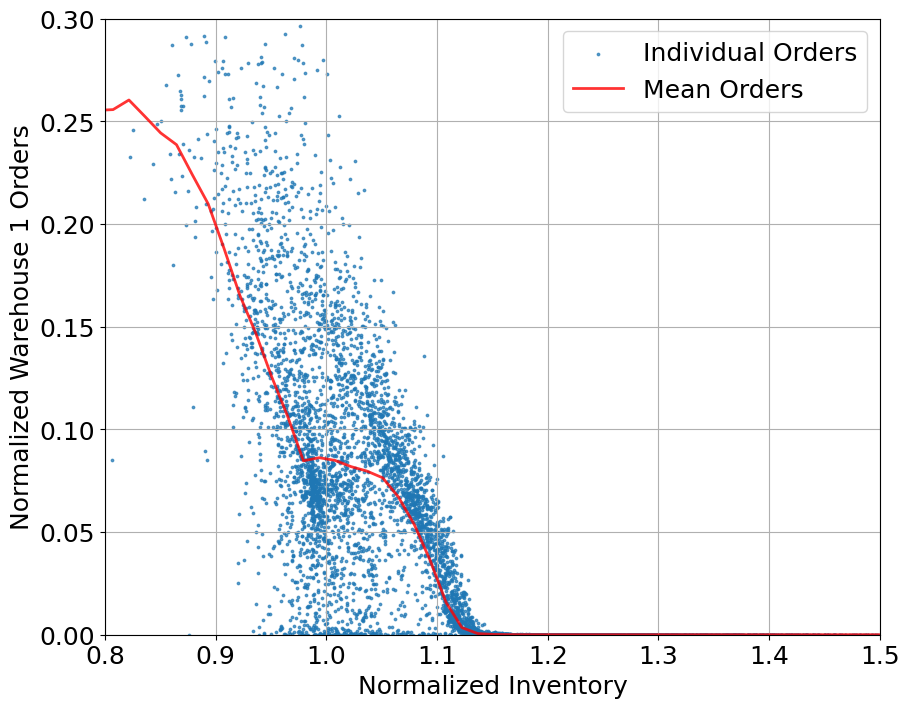

In [24]:
target_data = data[0]
n_samples = 8192
all_inventories = []
all_w1_orders = []

for t in range(n_steps-1):
    # Get indices for this timestep across all samples
    current_step_indices = range(t * n_samples, (t + 1) * n_samples)
    
    for store_idx in range(1):
        inv0 = target_data[f's_{store_idx}_inventory_0'].iloc[current_step_indices].values
        inv1 = target_data[f's_{store_idx}_inventory_1'].iloc[current_step_indices].values
        w1_orders = target_data[f's_{store_idx}_w_1_order'].iloc[current_step_indices].values
        demand_mean = target_data[f's_{store_idx}_demand_mean'].iloc[current_step_indices].values
        inv = (inv0 + inv1) / 2 / demand_mean

        # current_inventory_0 = target_data[f's_{store_idx}_inventory_0'].iloc[current_step_indices].values
        # current_demand = target_data[f's_{store_idx}_demand'].iloc[current_step_indices].values
        # valid_mask = current_inventory_0 > demand_mean * 1.15
        # inv = inv[valid_mask]
        # w1_orders = w1_orders[valid_mask] 
        # demand_mean = demand_mean[valid_mask]
        
        all_inventories.extend(inv)
        all_w1_orders.extend((w1_orders / demand_mean))

# Convert to numpy arrays and randomly sample 10000 points
all_inventories = np.array(all_inventories)
all_w1_orders = np.array(all_w1_orders)
sample_indices = np.random.choice(len(all_inventories), size=7000, replace=False)
plt.figure(figsize=(10, 8))
plt.scatter(all_inventories[sample_indices], all_w1_orders[sample_indices], alpha=0.7, s=3, label='Individual Orders')

# Calculate mean orders for each inventory bin
bins = np.linspace(all_inventories.min(), all_inventories.max(), 100)
bin_indices = np.digitize(all_inventories, bins)
mean_orders = np.array([all_w1_orders[bin_indices == i].mean() for i in range(1, len(bins)+1)])

plt.plot(bins, mean_orders, '-', linewidth=2, label='Mean Orders', color='red', alpha=0.8)
plt.xlabel('Normalized Inventory')
plt.ylabel('Normalized Warehouse 1 Orders')
plt.legend()
plt.ylim(0, 0.3)
plt.xlim(0.8, 1.5)
plt.grid(True)
plt.show()

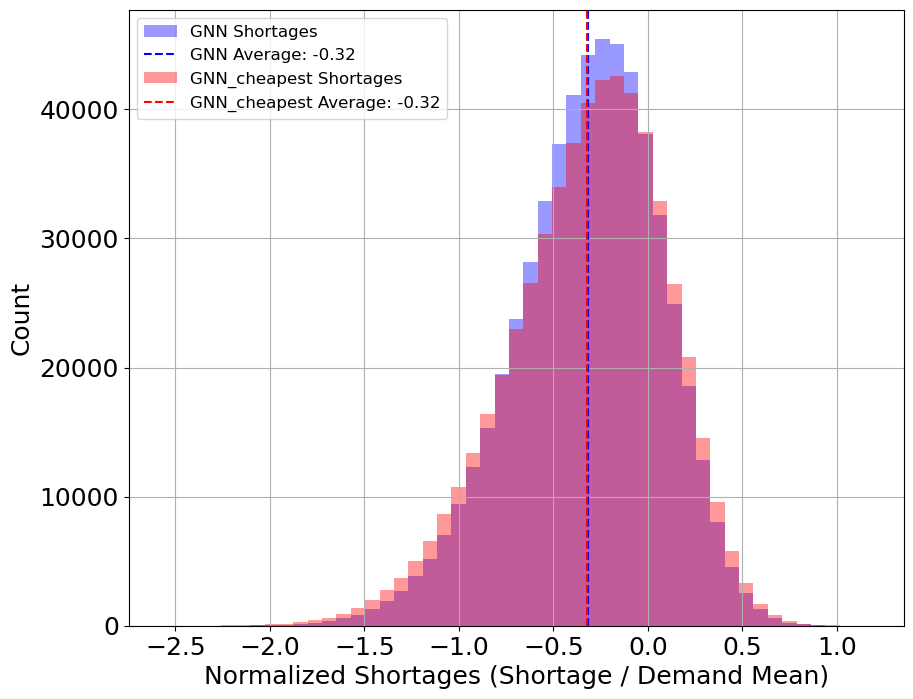

In [25]:
# Process data for both architectures
all_shortages = []
arch_labels = ['GNN', 'GNN_cheapest']
colors = ['blue', 'red']

for arch_idx in range(2):
    target_data = data[arch_idx]
    n_samples = 8192
    shortages_list = []

    for t in range(70-1):
        # Get indices for this timestep across all samples
        current_step_indices = range(t * n_samples, (t + 1) * n_samples)
        
        for store_idx in range(1):
            demands = target_data[f's_{store_idx}_demand'].iloc[current_step_indices].values
            current_inventory = target_data[f's_{store_idx}_inventory_0'].iloc[current_step_indices].values
            demand_mean = target_data[f's_{store_idx}_demand_mean'].iloc[current_step_indices].values
            
            shortages = demands - current_inventory
            shortages_list.extend(shortages / demand_mean)
    all_shortages.append(np.array(shortages_list))

# Plot histograms
plt.figure(figsize=(10, 8))

# Calculate common bin range across both datasets
min_val = min(np.min(all_shortages[0]), np.min(all_shortages[1]))
max_val = max(np.max(all_shortages[0]), np.max(all_shortages[1]))
bins = np.linspace(min_val, max_val, 50)

for arch_idx in range(2):
    sampled_data = all_shortages[arch_idx]
    mean_value = np.mean(all_shortages[arch_idx])
    
    plt.hist(sampled_data, bins=bins, alpha=0.4,
             label=f'{arch_labels[arch_idx]} Shortages', color=colors[arch_idx])
    plt.axvline(x=mean_value, color=colors[arch_idx], linestyle='--',
                label=f'{arch_labels[arch_idx]} Average: {mean_value:.2f}')

plt.xlabel('Normalized Shortages (Shortage / Demand Mean)')
plt.ylabel('Count')
plt.legend(prop={'size': 12})
plt.grid(True)
plt.show()

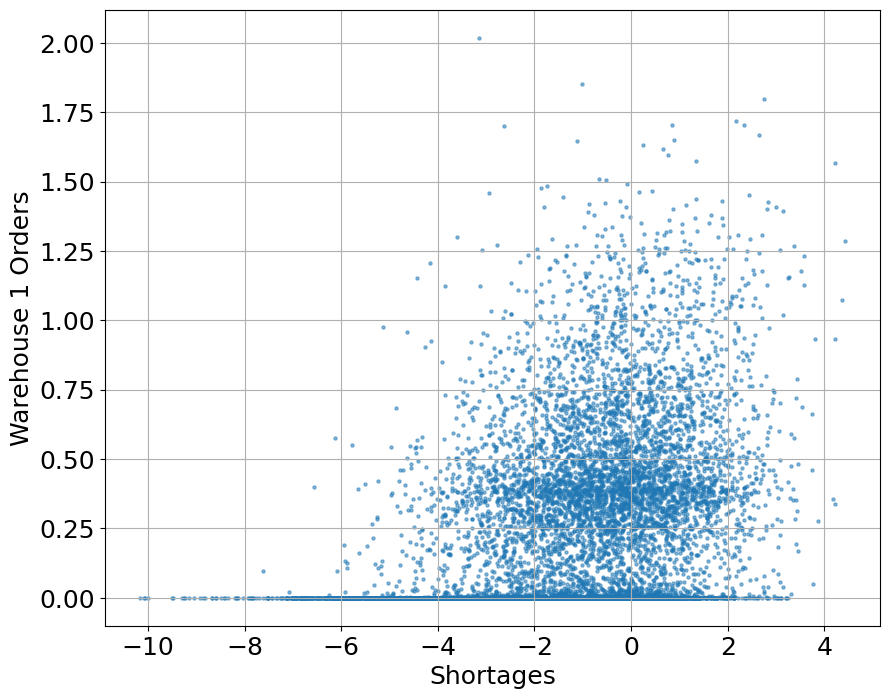

In [8]:
target_data = data[0]
n_samples = 8192
all_shortages = []
all_w1_orders = []

for t in range(70-1):
    # Get indices for this timestep across all samples
    current_step_indices = range(t * n_samples, (t + 1) * n_samples)
    future_demand_indices = range((t + 1) * n_samples, (t + 2) * n_samples)
    future_inventory_indices = range((t + 1) * n_samples, (t + 2) * n_samples)
    
    # valid_samples = abs(w0_inventory - w0_total_orders) > 0.1 
    # current_step_indices = [i for i, valid in zip(current_step_indices, valid_samples) if valid]
    # future_demand_indices = [i for i, valid in zip(future_demand_indices, valid_samples) if valid]
    # future_inventory_indices = [i for i, valid in zip(future_inventory_indices, valid_samples) if valid]

    for store_idx in range(1):
        future_demands = target_data[f's_{store_idx}_demand'].iloc[future_demand_indices].values
        w1_orders = target_data[f's_{store_idx}_w_1_order'].iloc[current_step_indices].values
        future_inventories = target_data[f's_{store_idx}_inventory_0'].iloc[future_inventory_indices].values
        future_inventories_without_w1_orders = future_inventories - w1_orders

        demand_mean = target_data[f's_{store_idx}_demand_mean'].iloc[future_demand_indices].values
        shortages = future_demands - future_inventories_without_w1_orders
        
        # Only include points where w1_orders > 0.1
        # valid_orders = w1_orders > 0.1
        # shortages = shortages[valid_orders]
        # w1_orders = w1_orders[valid_orders] 
        # demand_mean = demand_mean[valid_orders]

        all_shortages.extend((shortages))
        all_w1_orders.extend((w1_orders))

# Convert to numpy arrays and randomly sample 10000 points
all_shortages = np.array(all_shortages)
all_w1_orders = np.array(all_w1_orders)
sample_indices = np.random.choice(len(all_shortages), size=10000, replace=False)

plt.figure(figsize=(10, 8))
plt.scatter(all_shortages[sample_indices], all_w1_orders[sample_indices], alpha=0.5, s=5)
plt.xlabel('Shortages')
plt.ylabel('Warehouse 1 Orders')
plt.grid(True)
plt.show()